In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import math
import sys
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from IPython.display import clear_output

from fastai.vision import *
from fastai.metrics import error_rate

from utils.helper_functions import *
from utils.accuracy_functions import *
from utils.segmentation_dataclass  import *
from utils.unet_trainer import unet_trainer_program
from utils.transformation_helper import plots_f, one_hot_encoding_array, get_example_image

In [3]:
# See your current version of python/anaconda
print (sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


<a id='unet_trainer'></a>
# [Click here to skip to the code](#general_training)


# Introduction to the notebook.


### Links to the relevant cells:
- [General Training Functions](#general_training): This section will be your general trainer for a single model
- [Training Tester](#training_tester): This section will allow you to test many different combinations at once
- [Model Tester](#model_tester): Explore aspects of your trained model (Work in progress...)
- [Transformation Tester](#transformation_tester): This section will allow you to look at the results of various transformations

# Introduction to Subimage Generation from Hyperstacks

Microscope images are unique in the sense that the individual channels within an image stack are independent.  In other words a subset of channels from a larger image stack can be assembled to create an entirely new, representative microscope image.  This principle allows us to use source image stacks to simulate a wide range of expected experimental images and train robust cell segmentation models.  Below is an example of how this might work with source image stacks stacks composed of three fluorescent labels and brightfield images taken at seven different focal planes:


<img src="images/dataloader.png" alt="drawing" width="700"/>



From the source image, a channel loading code is used to arrange the source channels into three distinct substack channels by the dataloader.

The use of loading codes permits more complex interactions with the source image stack's channels, providing the dataloader with the following abilities: 

* **Simple Loading**: Load a specific channel from the 10-channel source image stack
* **Randomization**: Load a single random channel from a predefined subset of channels
* **Channel Dropout**: Perform a randomized test against a dropout percentage.  Load the channel normally if passed; load a blank channel otherwise
* **Merge**: Merge the contents from multiple channels into a single channel before loading 
* **Merge Dropout**: Perform a randomized test against a dropout percentage and only include that particular channel in the merge if passed

More on the channel loading codes below


<a id='loading_codes'></a>

## Channel Loading Codes

Each image input into the model will be generated from the source image using a **loading code**.  This loading code will outline how each of the three channels will be composed.  For example, a loading code of [0,3,6] will result in an image where channel 1 is loaded according to the loading instruction for code 0; code 3 for channel 2, and code 6 for the third channel.  The behaviour assigned to each code is defined in the utils/segmentation_dataclass.py script, and can be modified to suit your individual needs.  Currently, the codes are defined as follows:
* **Codes 0-50**: Simple loading.  Will load the channel corresponding to that number in the source image without further modificiation (e.g. 0 will load the first channel from the source image while 7 with load the 8th channel)
* **Codes 51-199**: Specialized loading.  This range of codes is reserved for defining more complex loading strategies such as fluorescence merge or channel randomization.  See below for the strategies that have currently been defined
* **Codes 200-399**: Dropout loading.  Performs a dropout test.  If it succeeds it will load the channel according to the code-200.  Otherwise it will load a blank channel.  For example, a code of 207 will default to code 7 if it passes the dropout test (207 - 200 = 7) or a black channel if it fails it.


The specialized codes can be redesigned or appended for new applications or datasets.  Currently, they are defined as:  
####  <ins>Codes related to the main dataset:</ins>
* 100: Merge All Fluorescence Channels
* 101: Random Lower Brightfield Channel
* 102: Random Upper Brightfield Channel
* 103: Random Brightfield Channel
* 104: Merge all Brightfield Channels
* 107: Any Random Channel
* 108: Random Fluorescence Channel
* 110: Black Channel
* 111: Dropout Merge of Fluorescence Channels  

#### <ins>Codes related to the external dataset:</ins>
* 121: Dropout Merge of Fluorescent Channels
* 122: Random Lower Brightfield Channel
* 123: Random Upper Brightfield Channel

The dropout test is performed against the dropout_chance variable and dropout merge is tested against the merge_dropout_chance variable.


<a id='general_training'></a>
# General Training Functions

The general training functions will allow you train either a single model or batch of models for cell segmentation and output them to a "Models" folder.

Note, this training functions will assume you have the following folders: <br>
1. A 'FullImage' folder containing your .ome.tif image files<br>
2. A 'Mask_Norm' folder containing your .png mask ground truths<br>  If you have not created this folder, [use the function located here](#mask_normalization)

### Before you begin, make sure that you have done the following:
- Once again, [normalized your masks](#mask_normalization).  If done correctly, you should have a 'Mask_Norm' folder containing your .png mask ground truths
- Determined the transforms you want to include in your data augmentation step.  Use the [transformation tester](#transformation_tester) to explore the effect of various transformations on your samples
- Added a codes.txt file to your training folder to outline which class each integer value in your masks belongs to.  It should have one label per line with nothing else.  For example:
```
Cell
Background
```
- Determine the correct [learning rate](#lr_finder) for your model.  

Follow the steps outlined in the cell below

<a id="parameters"></a>
## Step 1 - Set your training parameters (for both the single and multi-model trainer)

### Basic Training Parameters

* **root_path**: The directory containing your images.  It should contain the following files and folders at a minimum:
    - The "FullImage" folder
    - The "Mask_Norm" folder
    - The "codes.txt" file
* **lr**: The maximum learning rate for your model.  Use the [learning rate finder](#lr_finder) to determine the optimal value for your application
* **bs**: The batch size.  Decrease this value if you run out of GPU ram
* **size**: The height and width that your images will be scaled to before entering the model
* **penalty**: How the loss of background pixels will be weighed relative to the foreground pixels.  Use [this module](#cross_entropy) to determine which value works best for your application 
* **custom_tfms**: The transforms that will be applied to your images during training.  See the [transformation explorer](#transformation_tester) to determine which values work best for you.  Comment out transformations that you don't need

In [4]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer')
lr = 2e-4                         
bs = 4                            
size = 400                        
penalty = 0.5

custom_tfms = [pad(padding=(4), mode = 'zeros', p=0.5),
               pad(padding=(2), mode = 'zeros', p=0.5),
               #rand_crop(padding_mode = 'zeros', p=0.2),
               rotate(degrees=(-180,180), p=1.),
               brightness(change = (0.3,0.65), p = 0.8),
               contrast(scale = (0.75, 1.25), p = 0.8),
               #jitter(magnitude = 1.0, p = 1.0),
               symmetric_warp(magnitude = (0,0.5), p = 1.0),
               rand_zoom(scale = (1.0, 1.1), p=1.0),
               dihedral(p = 1.0)
              ]
tfms = (custom_tfms, [crop_pad()])

### End of Common Route
From here, either jump to the:
- [Single Trainer](#single_trainer)
- [Multimodel Trainer](#training_tester)

<a id='single_trainer'></a>
## Step 2 (For Single Trainer Only)

This cell will train a single model using the parameters defined above as well as the following additional inputs:

* **export_name**: The output name for the trained model.  It will be stored in the Models directory
* **channel_codes**: The loading codes for your images as [discussed here](#loading_codes)
* **channel_dropout_rate**: The dropout rate for the channels in your images.  0.0 means no dropout while 1.0 means full dropout
* **merge_dropout_rate**: Defines the rate of dropout for each channel contributing to your merge operations
* **reuse_old_model**: Set this to True if you would like to load a previous model's weights, rather than to reinitialize it with the default parameters
* **old_model_name**: If you are reusing an old model, specify its name here
* **train_mode**: Set this to False if you would like to return a learner without actually training the model 

After training, you can explore your trained model in the [model tester](#model_tester)

In [7]:
export_name = 'DefaultModel.pkl'  #Export Name
channel_codes = [0,3,6]
channel_dropout_rate = 0.0
merge_dropout_rate = 0.0
reuse_old_model, old_model_name = False, 'Starter' 
train_mode = True

learner, cache = unet_trainer_program(root_path,
                                      training_parameters = (channel_codes, channel_dropout_rate, merge_dropout_rate),
                                      tfms = tfms, 
                                      bs = bs, 
                                      lr = lr, 
                                      size = size, 
                                      model = models.resnet34,
                                      export_name = export_name,
                                      train_mode = train_mode,  
                                      return_cache = True, #This will return learn, cache instead of just learn
                                      reuse_old_model = reuse_old_model,
                                      output_cache = True,
                                      old_model_name = old_model_name,
                                      penalty = penalty, #High values will punish saying it's the bkgd and getting it wrong
                                     )

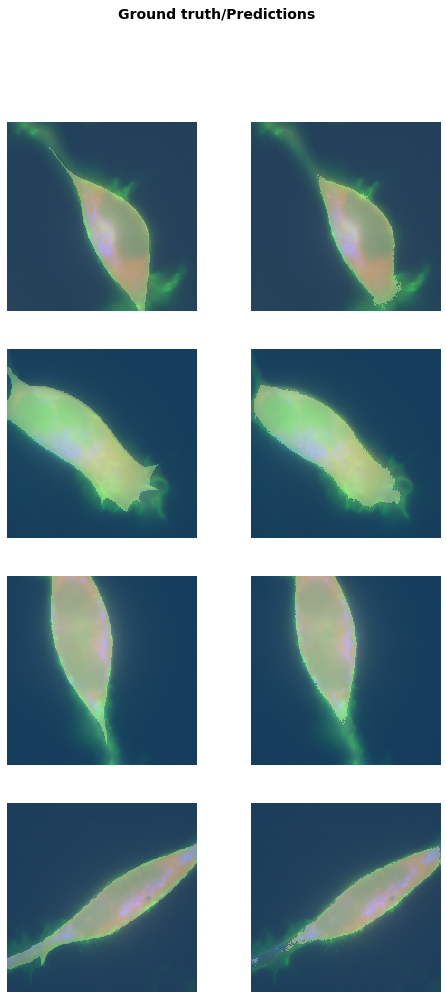

In [8]:
learner.show_results(3)

<a id='training_tester'></a>
# Multimodel Trainer (For comparing models)
Continued from [Step 1 above](#general_training)


## Step 2 - Choose the additional parameters for the models you will train
Multimodel training works very similarly to single model training, but iterates through a list of model parameters and trains them all. After training, the subsequent two cells create both a bar graph and a training line graph for easy visualization.  There are three steps involved in multimodel training.  The first is to set the **TRAINING_CHANNELS**.  This will be a list of tuples containing the training information for each model.  Each tuple is structured as:  

(Name, Channel_Codes, Channel_Dropout_Rate, Merge_Dropout_Rate)  

For example,  ('Fluorescence', [0,3,6], 0.3, 0.7)

As before: 
* **Name**: The output name for the trained model.  It will be stored in the Models directory
* **Channel_Codes**: The loading codes for your images as [discussed here](#loading_codes).
* **Channel_Dropout_Rate**: The dropout rate for the channels in your images.  0.0 means no dropout while 1.0 means full dropout. 
* **Merge_Dropout_Rate**: Defines the rate of dropout for each channel contributing to your merge operations.

Many templates have been provided corresponding to the figures in "Cell segmentation using deep learning: comparing label and label-free approaches using hyper-labeled image stacks"

Run the cell for the template of your choice (or create your own) and move on to the dataset step

**Templates for figures from the main dataset can be found [here](#main_templates)**  
**Templates for figures from the external dataset can be found [here](#external_templates)**

In [7]:
"""Example """
dropout = 0.0
merge_dropout = 0.0
TRAINING_CHANNELS = [('Fluorescence Dropout', [200,203,206], dropout, merge_dropout),
                     ('Channel 1', [0,110,110], 0, 0),
                     ('Channel 2', [110,3,110], 0, 0),
                     ('Channel 3', [110,110,6], 0, 0),
                     ('All Random' , [107, 107, 107] ,0, 0),
                     ('All Infocus BR' , [12, 12, 12], 0, 0),
                     ('All Black', [110, 110, 110], 0, 0)
                    ]

## Step 3 - Choose your dataset

Comparing models works best when you use the same training-validation split.  Set your dataset name with **dataset_name**.  If there is no dataset with that name, it will make a new one.  Otherwise, it will reload the old one so you can keep the dataset consistent. 

In [10]:
dataset_name = "Dataset1"

if not (root_path/f'{dataset_name}.pkl').exists():
    data = get_data(root_path = root_path, tfms=tfms, size = size, bs=bs)
    data.save(root_path/f'{dataset_name}.pkl')
data = load_data(root_path, f'{dataset_name}.pkl', num_workers = 0, bs=bs)

## Step 4 - Train your models

In [9]:
figures_path = find_folder_name(root_path)
loss_results, acc_results, final_acc = [], [], []
training_labels = [f"{x}, Dr{y}, SDr{z}" for (x, _, y, z) in TRAINING_CHANNELS]

for name, training_channels, channel_dropout, merge_dropout in TRAINING_CHANNELS:
    print ('Currently working on', name, training_channels, channel_dropout, merge_dropout)
    learner, cache = unet_trainer_program(root_path,
                                          export_name = f'{name}.pkl',
                                          training_parameters = (training_channels, channel_dropout, merge_dropout),
                                          tfms = tfms, 
                                          bs = bs, 
                                          lr = lr, 
                                          size = size, 
                                          model = models.resnet34,
                                          data = data,
                                          train_mode = True,  #Keep this as true since we are training
                                          return_cache = True,#Keep this as true
                                          penalty = penalty,
                                          #reuse_old_model = reuse_old_model,
                                          #old_model_name = old_model_name
                                         )
    
    loss_r, acc_r = cache['Loss'], cache['Accuracy']
    final_a = acc_r[-5:].mean()

    loss_results.append(loss_r)
    acc_results.append(acc_r)
    final_acc.append(final_a)
    
    np.savetxt(figures_path/f'Loss {name} {training_channels} {channel_dropout}{merge_dropout}.txt', loss_r, delimiter = '\n')
    np.savetxt(figures_path/f'Accuracy {name} {training_channels} {channel_dropout}{merge_dropout}.txt', acc_r, delimiter = '\n')   
    
acc_results_new = np.concatenate(acc_results, axis = 1)
output_dataframe(loss_results, training_labels, figures_path/'loss_results.csv')
for i, tag in enumerate(['overall', 'background', 'cell']):
    output_dataframe(np.array(acc_results)[:,:,i], training_labels, figures_path/f'acc_results_{tag}.csv')

Currently working on Fluorescence Dropout [200, 203, 206] 0.0 0.0


Currently working on Channel 1 [0, 110, 110] 0 0


Currently working on Channel 2 [110, 3, 110] 0 0


Currently working on Channel 3 [110, 110, 6] 0 0


Currently working on All Random [107, 107, 107] 0 0


Currently working on All Infocus BR [12, 12, 12] 0 0


Currently working on All Black [110, 110, 110] 0 0


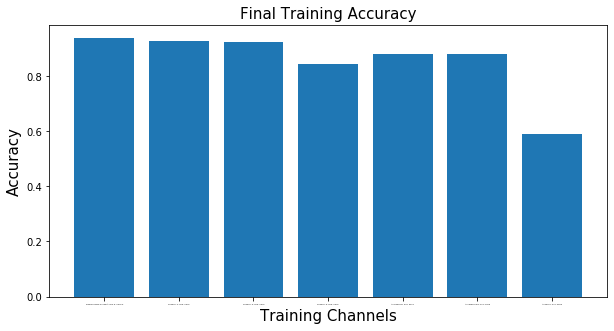

In [10]:
# Accuracy Bar Graphs
training_labels = [f"{x}, Dr{y}, SDr{z}" for (x, _, y, z) in TRAINING_CHANNELS]
num_labels = len(final_acc)

plt.figure(figsize = (10,5))
plt.bar(range(num_labels), final_acc)
plt.xticks(range(num_labels), training_labels, fontsize = 2)
plt.ylabel("Accuracy", fontsize = 15)
plt.xlabel ("Training Channels", fontsize = 15)
plt.title("Final Training Accuracy", fontsize = 15)
plt.savefig(figures_path/'accuracy.eps', format = 'eps' )
plt.savefig(figures_path/'accuracy.png', format = 'png' )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


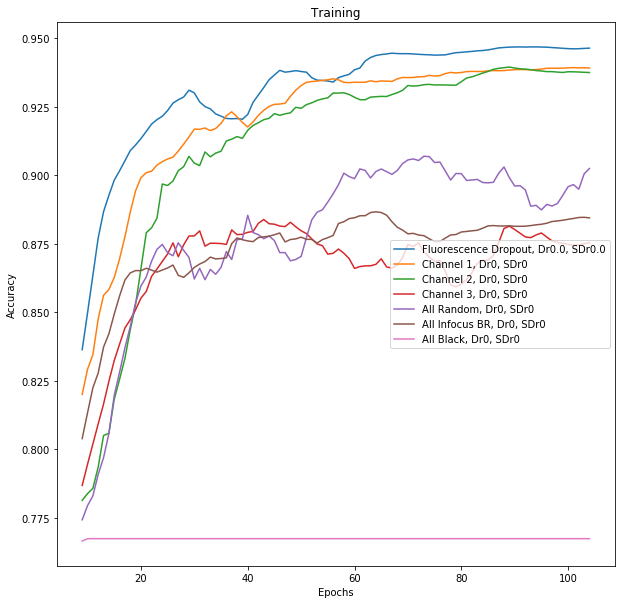

In [11]:
# Training Line Graphs
rolling_window = 10
plt.figure(figsize = (10,10))

for i, label in enumerate(training_labels):
    if rolling_window:
        plt.plot(pd.Series(np.array(acc_results)[i,:,0].squeeze()).rolling(rolling_window).mean(), label = label)
    else: plt.plot(acc_results[i], label = label)

plt.title("Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 0)
plt.savefig(figures_path/'train_accuracy.eps', format = 'eps' )
plt.savefig(figures_path/'train_accuracy.png', format = 'png' )

# Additional Functions

# Model Validation on a Test Set

Model validation takes your pretrained models and validates them on an external test set.  It requires you to define four variables:
* **root_path**: The path to your folder
* **output_name**: The name of your output file.  Should end in .csv
* **dropout_rates**: The dropout rates that you want to test on your models.  Should be a list of tuples for dropout_rate and merge_dropout_rate
* **TRAINING_CHANNELS**: Use a 1 if you want to include dropout, otherwise set it to 0.  The model names here must correspond to the exported model names from your training

**Note**: The models you want should be copied to the Models folder in the test dataset's root folder

In [12]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer - Test')
output_name = 'acc_results_test.csv'
dropout_rates= [(x,x) for x in np.linspace(0,1,3)]
TRAINING_CHANNELS = [('Channel 1', [0,110,110], 0, 0),
                     ('Channel 2', [110,3,110], 0, 0),
                     ('Channel 3', [110,110,6], 0, 0),
                     ('All Random' , [107, 107, 107] ,0, 0),
                     ('All Infocus BR' , [12, 12, 12], 0, 0),
                     ('Fluorescence Dropout', [200,203,206], 1, 0),                      
                     ('All Black', [110, 110, 110], 0, 0)]

In [13]:
mask_path, seg_path, codes_path, model_path, figures_path, codes = load_core_paths(root_path)
get_mask_func = get_y_lambda_function(root_path)

loss_results, acc_results, final_acc = [], [], []
training_labels = [f"{x}, Dr{y}, SDr{z}" for (x, _, y, z) in TRAINING_CHANNELS]
final_acc = training_labels

data = (SegMultiImageList
         .from_folder(seg_path, recurse = True)
         .split_by_rand_pct(1)
         .label_from_func (get_mask_func, classes = codes)
         .transform(tfms =tfms, size = size, tfm_y = True, padding_mode = 'border')#, resize_method=ResizeMethod.SQUISH)
         .databunch(bs = 4, num_workers = 0))

for (dropout, merge_dropout) in dropout_rates:
    training_channels = [(n, tc, drop * dropout, merge * merge_dropout) for (n, tc, drop, merge) in TRAINING_CHANNELS]
    acc_results=[]
    for i, (name, training_channels, dropout_rate, merge_dropout) in enumerate(training_channels):
        clear_output(wait = True)
        print ('[{i+1}/{len(training_channels)}] Currently working on', name, training_channels, dropout_rate, merge_dropout)
        data.set_training_parameters(training_channels, dropout_rate, merge_dropout)
        learn = load_learner(model_path, name + ".pkl")
        learn.data = data
        (loss, *accuracy) = learn.validate()
        acc_results.append(accuracy[0] if isinstance(accuracy, list) else accuracy)
        loss_results.append(loss)
    final_acc = np.vstack((final_acc,acc_results))


results_df_acc= pd.DataFrame(final_acc)
results_df_acc.to_csv(figures_path/output_name)
print(f"Done.  See your results in {figures_path/output_name}")

Currently working on All Black [110, 110, 110] 0.0 0.0


Done.  See your results in {figures_path/output_name}


<a id='model_tester'></a>
## Model Explorer - Output all predictions

This module wil allow you to visually explore how well your model is doing by outputting the predictions for each image to the folder "Models"/{Your Model Name}.  For example, the outputs for "Channel 1.pkl" will be in "Models/Channel 1"

For each image, the following will be output with identifying suffixes:
* **Orig**: The input image as loaded by loading channel codes
* **X**: The cropped and resized version that enters the model
* **Pred**: The predicted cell mask for the image
* **Overlay**: An overlay between the image and the prediction



As before, you will have to define the following variables:
* **root_path**: Path to the folder containing your images, models, etc.
* **model_name**: The name of your model in the "Models" folder.  Don't include the ".pkl"
* **channel_codes**: The loading codes for your images as [discussed here](#loading_codes)
* **size**: The size you want your images to be resized to when entering the model.  For best results, use the same size that you trained with

In [14]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer')
model_name = 'Channel 1'
channel_codes = [0,110,110]
size = 400

In [15]:
mask_path, seg_path, codes_path, model_path, figures_path, codes = load_core_paths(root_path)
get_mask_func = get_y_lambda_function(root_path)
data = (SegMultiImageList
         .from_folder(seg_path, recurse = True)
         .split_none()
         .label_from_func (get_mask_func, classes = codes)
         .transform(tfms =[None, None], size = size, tfm_y = True, padding_mode = 'border')#, resize_method=ResizeMethod.SQUISH)
         .databunch(bs = 1, num_workers = 0))
data.set_training_parameters(channel_codes, 0, 0)

learn = load_learner(model_path, model_name+'.pkl')
learn.data = data

images = learn.data.train_ds.items
learn.callbacks.append(RecordOnCPU())
for filepath in images:
    img = data.open_image_2(filepath)
    pred = learn.predict(img)
    *callbacks,rec_cpu = learn.callbacks
    x,y = rec_cpu.input,rec_cpu.target
    
    fig,ax = plt.subplots()
    ax.imshow(image2np(x[0,...]), cmap=defaults.cmap, alpha=1)
    ax.imshow(image2np(pred[1].data), cmap=defaults.cmap, alpha=0.5)
    ax.axis('off')
    
    output_path = (model_path/model_name/str(filepath.relative_to(seg_path))).parent
    output_path.mkdir(exist_ok = True, parents = True)
    
    img.save(model_path/model_name/str(filepath.relative_to(seg_path)).replace('.ome.tif', '_Orig.png'))    
    imageio.imsave(model_path/model_name/str(filepath.relative_to(seg_path)).replace('.ome.tif', '_Pred.png'), (image2np(pred[1].data)*255).astype('uint8'))
    imageio.imsave(model_path/model_name/str(filepath.relative_to(seg_path)).replace('.ome.tif', '_X.png'), (image2np(x[0,...])*255).astype('uint8'))

    plt.savefig(model_path/model_name/str(filepath.relative_to(seg_path)).replace('ome.tif', '_Overlay.png'))
    plt.close()
    
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


<a id='transformation_tester'></a>
# Explore possible transformations

Data augmentation is a simple way to vastly expand the variety of data that's shown to the model.  This helps the model generalize well to new, unseen inputs.  It's important to choose your data augmentation transformations so that the cells it produces still look within the realm of realism.  Use this module to investigate the appropriate range of transformations for your application.  The **custom_tfms** variable you play around with in Step 2a will be directly copied to the [parameters](#parameters) section of the notebook.

The variables you will have to set are:
* **root_path**: Path to the folder containing your images, models, etc.
* **example_image_path**: The relative path to your image of interest, starting from the root_path
* **channel_codes**: The loading codes for your images as [discussed here](#loading_codes)
* **size**: The final resize size of the images.  Usually best to keep it the same as the one you'd use for your training
* **output_name**: The base filename for the generated figures.  They will be found in Figures/{output_name} unless otherwise noted

## Step 1 - Select image and path

In [16]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer')
example_image_path = root_path/Path(r"FullImage\AD293\20190318AD293Cindy\1_7_MMStack_Pos00.ome.tif")
channel_codes = [0,3,6]
size = 400
output_name='fluorescence_transforms'

mask_path, seg_path, codes_path, model_path, figures_path, codes = load_core_paths(root_path)

## Step 2a - Transformation Explorer (Apply All)

This cell will apply the transformation in custom_tfms to your example image (found in example_image_path).  If they are within an acceptable range, copy and paste them into the custom_tfms variable found in the [parameters section](#parameters)

In [17]:
custom_tfms = [pad(padding=(4), mode = 'zeros', p=0.5),
               pad(padding=(2), mode = 'zeros', p=0.5),
               #rand_crop(padding_mode = 'zeros', p=0.2),
               rotate(degrees=(-180,180), p=1.),
               brightness(change = (0.3,0.65), p = 0.8),
               contrast(scale = (0.75, 1.25), p = 0.8),
               #jitter(magnitude = 1.0, p = 1.0),
               symmetric_warp(magnitude = (0,0.5), p = 1.0),
               rand_zoom(scale = (1.0, 1.1), p=1.0),
               dihedral(p = 1.0),
               #add skew
              ]

fig = plots_f(4,4,size,size, example_image_path, custom_tfms, channel_codes)
plt.savefig(figures_path/f'{output_name}_all.svg')

## Step 2b - Transformation Explorer (Apply Individually)

You can apply each transformation on your example image individually to see their effects.
The following trasnformations have ranges that you can alter, if you wish:
* **Brightness**: Full range is between 0 and 1
* **Contrast**: Full range is between 0 and 1
* **Crop**: The image size the original will be cropped to before the final resizing
* **Jitter**: From 0 onwards
* **Pad**: From 0 onwards.  Detemined how many pixels to pad the input image by
* **Rotate**: 0 to 360 (degrees)
* **Skew Magnituge**: 0 onwards
* **Symmetric Warp Ones Side**: 0 onwards
* **Symmetric Warp All**: 0 onwards

**ntests** determines how many tests should be performed for the transformations that iterate over a range.

In [18]:
ntests = 10
DIRECT_TFMS = {("Brightness", brightness): [{'change': x} for x in np.linspace(0,1,num=ntests)], 
              ("Contrast", contrast):[{'scale': x} for x in np.linspace(0,1,num = ntests)], 
              ('Crop', crop):[{'size':(sz, sz), 'row_pct':0.9, 'col_pct':0.9} for sz in range(200,500,50)],
              ('Crop Pad', crop_pad):[{'size':sz, 'padding_mode':'border'} for sz in range (200, 700, 50)],
              ('Dihedral', dihedral):[{'k':x} for x in range(8)],
              ('Flip LR', flip_lr):[{}],
              ('Jitter', jitter):[{'magnitude':x} for x in np.linspace(0,0.5, ntests)],
              ('Pad', pad):[{'padding':x, 'mode':'border'} for x in range(0,40,4)],
              ('Perspective Warp Direction', perspective_warp):[{'magnitude':one_hot_encoding_array(x, 1)} 
                                                                for x in range(8)],
              ('Perspective Warp Magnitude', perspective_warp):[{'magnitude':one_hot_encoding_array(0, x)} 
                                                                for x in np.linspace(0,1,ntests)],
              ('Rotate', rotate):[{'degrees':x} for x in np.linspace(0,360, ntests)],
              ('Skew Direction', skew): [{'direction':x, 'magnitude':2} for x in range(8)],
              ('Skew Magnitude', skew): [{'direction':0, 'magnitude':x} for x in np.linspace(0,10,ntests)],
              ('Symmetric Warp One Side', symmetric_warp): [{'magnitude':(0,0,0,x)} for x in np.linspace(0,1, ntests)],
              ('Symmetric Warp All', symmetric_warp): [{'magnitude':(x,x,x,x)} for x in np.linspace(0,1, ntests)],        
             }

### Output individual transformations as images
Running this next cell will output all the transformed images to Models/{output_name}/{transformation_name} as individual files

In [19]:
get_img = partial(get_example_image, example_image_path, channel_codes)
nrows = len(DIRECT_TFMS) #+ len(INDIRECT_TFMS)
ncols = ntests + 1
FONTSIZE = 30
c, h, w = get_img().shape
nlchar = '\n'
save_folder = Path(figures_path/output_name); save_folder.mkdir(exist_ok = True)


for row, ((name, tfm), parameters) in enumerate(DIRECT_TFMS.items()):
    for col, kwargs in enumerate(parameters):
        img = get_img()
        tfm(img, **kwargs)#.resize((3,400,400))
        img.save(save_folder/f'{name}, {str(kwargs).replace(":", "").replace(nlchar, "")}.png')

### Output individual transformations as a figure
If your computer can handle it, you can run the code below to arrange all the outputs from the individual transformations in a single figure

In [ ]:
get_img = partial(get_example_image, example_image_path, channel_codes)
nrows = len(DIRECT_TFMS) #+ len(INDIRECT_TFMS)
ncols = ntests + 1
FONTSIZE = 30
resize_size = 50
c, h, w = get_img().resize(resize_size).shape

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (h,w))
for row, ((name, tfm), parameters) in enumerate(DIRECT_TFMS.items()):
    for col, kwargs in enumerate(parameters):
        tfm(get_img().resize(resize_size), **kwargs).show(ax[row][col])
        ax[row][col].set_title(str(kwargs), fontsize = FONTSIZE)
    ax[row][-1].text(0.1, 0.8, name, fontsize = FONTSIZE*3)
    ax[row][-1].text(0.1, 0.4, str(parameters[0]), fontsize = FONTSIZE*3)
    ax[row][-1].text(0.1, 0.1, str(parameters[-1]), fontsize = FONTSIZE*3)
    ax[row][-1].axis('off')

fig.savefig(figures_path/f'{output_name}_individual.svg')

<a id = 'lr_finder'></a>
# Find your Learning Rate

The learning rate will determine the rate at which your model parameters get updated.  Too high and the fit will diverge.  Too slow and it will take a long time to reach a local minimum.  Use this function to find your learning rate.  

**Make sure to initialize your parameters [here](#parameters) before you continue (set the learning rate to anything)**

Set the following parameters below:
* **root_path**: path to the folder containing your images, models, etc.
* **unfreeze_mode**: Set to True if you want to determine the learning rate when the network is unfrozen.  Otherwise the first half will be frozen.  The lr you set in your parameters will be for the frozen network, so it is recommended to leave it as False
* **LR_CHANNELS**: The name and channel loading codes (as discussed [here](#loading_codes))

In [20]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer')
unfreeze_mode = False
LR_CHANNELS = [('Fluorescence', [0,3,6]), #fluorescence
               ('Ch1', [0,110,110]),
               ('Ch2', [110,3,110]),
               ('Ch3', [110,110,6]),
               ('Low Brightfield' , [11,12,13]), #Low OoF Brightfield
               ('Med Brightfield' ,[10,12,14]), #Med OoF Brightfield
               ('High Brightfield' , [9,12,15]), #High OoF Brightfield
               ('Merge and Brightfield' , [100, 12, 13]), #Merge and Brightfield
               ('All Random' , [107, 107, 107]), #All Random
               ('All Infocus BR' , [12, 12, 12]), #Only In-focus Brightfield
               ('RND Brightfield Above and Below', [101, 12, 102]),
               ('Fluorescence Merge and Brightfield', [111, 12, 13]),
                ]

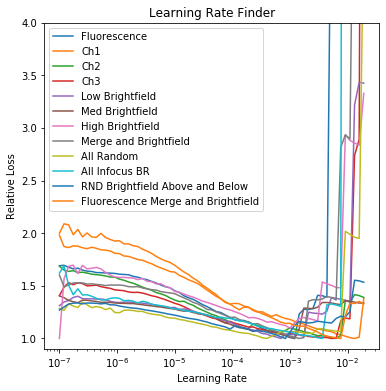

In [21]:
def lr_comparison(name, channels, entries = None, unfreeze_mode = True):
    if entries is None: entries = OrderedDict()
        
    learn, cache = unet_trainer_program(root_path, 
                                        training_parameters = (channels, 0, 0),
                                        tfms = tfms, 
                                        bs = bs, 
                                        lr = lr, 
                                        size = size, 
                                        model = models.resnet34,
                                        train_mode = False,  
                                        return_cache = True, #This will return learn, cache instead of just learn
                                        reuse_old_model = False,
                                        old_model_name = None)
    lrs, losses = [], []    
    if unfreeze_mode:
        learn.fit_one_cycle(5, max_lr = 2e-4)
        learn.unfreeze()
        
    learn.lr_find()
    
    lr_array = list(map(float, learn.recorder.lrs))
    loss_array = list(map(float, learn.recorder.losses))
    entries[name+'unfrozen_learning_rates'] = lr_array
    entries[name + 'unfrozen_losses'] = loss_array
    lrs.append(learn.recorder.lrs)
    losses.append(learn.recorder.losses)
    
    return entries

#---------------- Finding the optimal learning rate ----------------
entries = OrderedDict()
for name, channels in LR_CHANNELS:
    print('Working on:', name, channels)
    lr_comparison(name, channels, entries, unfreeze_mode = unfreeze_mode)
    
# Output learning rate results to CSV    
results = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in entries.items()})
lr_save_path = root_path/'Learning Rates'; lr_save_path.mkdir(exist_ok=True)
lr_save_name = lr_save_path/'learning_rates.csv'
counter = 0
while lr_save_name.exists(): #Make sure you don't overwrite anything
    lr_save_name = lr_save_path/f'learning_rates_{counter:03}.csv'
    counter += 1
results.to_csv(lr_save_name)

# Output learning rate graphs
clear_output(wait = True)
plt.figure(figsize=(6,6))
for index, (name, channels) in enumerate(LR_CHANNELS):
    i = index*2+1
    mean = results.iloc[:, i].min()
    losses = (results.iloc[:, i])/mean
    x = results.iloc[:, i-1]
    plt.plot(x[:-5], losses[:-5])
    
plt.legend([name for name, _ in LR_CHANNELS])
plt.xscale('log')
plt.title('Learning Rate Finder')
plt.ylabel('Relative Loss')
plt.xlabel('Learning Rate')
plt.ylim(0.9,4)
plt.savefig(lr_save_path/'learning_rates.png')
plt.show()

<a id="cross_entropy"></a>
# Cross Entropy

Weighing the background and cell losses differently will encourage the model to either tend to oversegment the cell, or undersegment the cell as shown here:

<img src="images/cross_entropy_penalty.png" alt="drawing" width="700"/>

There is a tradeoff between accuracy of the cell pixels and the background pixels as seen in the following graph:
<br></br>

<img src="images/penalties_tradeoff.png" alt="drawing" width="400"/>


Deciding which is most important to your analysis will determine which weight value to set.  Once you have a value, it should be set to **penalty** in the [parameters](#parameters) section of the notebook.


* **root_path**: Path to the folder containing your images, models, etc.
* **model_name**: The name of your model in the "Models" folder.  Don't include the ".pkl"
* **channel_codes**: The loading codes for your images as [discussed here](#loading_codes)
* **penalties**: a list of penalties that will be tested

**Make sure to initialize your parameters [here](#parameters) before you continue (set the penalty to anything)**

In [5]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer')
base_export_name = 'Fluorescence-penalty'
channel_codes = [0,3,6]
penalties = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000]

In [7]:
figures_path = find_folder_name(root_path)
loss_results, acc_results, final_acc = [], [], []
training_labels = [str(x) for x in penalties]

for i, p in enumerate(penalties):
    clear_output(wait = True)
    print (f'[{i+1}/{len(penalties)}] Currently working on penalty = {p}')
    learner, cache = unet_trainer_program(root_path,
                                          export_name = f'{base_export_name}, Penalty:{penalty}.pkl',
                                          training_parameters = (channel_codes, 0, 0),
                                          tfms = tfms, 
                                          bs = bs, 
                                          lr = lr, 
                                          size = size, 
                                          model = models.resnet34,
                                          train_mode = True,  #Keep this as true since we are training
                                          return_cache = True,#Keep this as true
                                          penalty = p,
                                         )
    
    loss_r, acc_r = cache['Loss'], cache['Accuracy']
    final_a = acc_r[-5:].mean()

    loss_results.append(loss_r)
    acc_results.append(acc_r)
    final_acc.append(final_a)
    
    np.savetxt(figures_path/f'Loss {base_export_name} - {p}.txt', loss_r, delimiter = '\n')
    np.savetxt(figures_path/f'Accuracy {base_export_name} - {p}.txt', acc_r, delimiter = '\n')   
    
#acc_results_new = np.concatenate(acc_results, axis = 1)
output_dataframe(loss_results, training_labels, figures_path/f'{base_export_name} - loss_results.csv')
for i, tag in enumerate(['overall', 'background', 'cell']):
    output_dataframe(np.array(acc_results)[:,:,i], training_labels, figures_path/f'{base_export_name} - acc_results_{tag}.csv')

clear_output(wait = True)
print(f"Done.  See your results in {figures_path}")

Done.  See your results in C:\Users\William\.data\Mask Trainer\Figures\2020-5-11 13


<a id = 'mask_normalization'></a>
# Mask Normalization

In [ ]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer')
mask_path = Path(r"Mask\INS1E\20190307W")

save_path = root_path/'Mask_Norm'/mask_path.relative_to(root_path/'Mask'); save_path.mkdir(parents = True ,exist_ok = True)
for files in mask_path.iterdir():
    reader = imageio.get_reader(str(files))
    img = reader.get_data(0)
    img = np.divide (img, 255).astype('uint8')
    imageio.imwrite(str(save_path/files.name), img)

# Filter Unlabelled

Be careful because this can delete files!!!

In [ ]:
root_path = Path(os.path.expanduser('~'))/Path(r'.data\Mask Trainer')

# root_image_path = root_path/'FullImage'
# root_mask_path = root_path/'Mask_Norm'

# for files in image_path.iterdir():
#     sub_path = files.relative_to(root_image_path)
#     sub_path = sub_path.parent/sub_path.name.replace('.ome.tif', '.png')
#     mask_path = root_mask_path/sub_path
#     if not mask_path.exists():
#             files.unlink()
    
    

<a id='main_templates'></a>
## Main Templates - jump back to the multimodel trainer [here](#training_tester)

In [ ]:
""" Figure 2c template"""

dropout_array = np.arange(0,1.1,0.1)

TRAINING_CHANNELS = [('Dropout Fluorescence', [200,203,206], x, 0) for x in dropout_array] + [('All Black', [110, 110, 110], 0, 0)]



In [ ]:
""" Figure 3c Template """

TRAINING_CHANNELS = [('All Infocus BR' , [12, 12, 12], 0, 0), # Only In-focus Brightfield
                     ('Low OoF' , [11, 12, 13], 0, 0), # Low OoF
                     ('Med OoF' , [10, 12, 14], 0, 0), # Medium OoF
                     ('High OoF' , [9, 12, 15], 0, 0), # High OoF
                     ('RND Brightfield Above and Below', [101, 12, 102],0,0),
                     ('All Black', [110, 110, 110], 0, 0), #All Black
                    ]

In [ ]:
""" Figure 4b Template """

TRAINING_CHANNELS= [(f'RND Brightfield Above and Below', [101, 12, 102],0,0),
                     (f'Merge and Brightfield' , [111, 12, 102], 0,0),
                     (f'Ch1 and Brightfield' , [200, 12, 102], 0, 0), 
                     (f'Ch2 and Brightfield' , [203, 12, 102], 0, 0),
                     (f'Ch3 and Brightfield' , [206, 12, 102], 0, 0),
                     (f'Fluorescence', [200,203,206], 0, 0),                      
                     (f'All Black', [110, 110, 110], 0, 0), 
                    ]

In [ ]:
""" Figure 4c Template """
TRAINING_CHANNELS = []
dataset = 1

for dropout in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    TRAINING_CHANNELS += [(f'RND Brightfield Above and BelowD{dataset}{dropout}', [101, 12, 102],0,0),
                     (f'Merge and BrightfieldD{dataset}{dropout}' , [111, 12, 102], 0, dropout),
                     (f'Ch1 and BrightfieldD{dataset}{dropout}' , [200, 12, 102], dropout, 0), 
                     (f'Ch2 and BrightfieldD{dataset}{dropout}' , [203, 12, 102], dropout, 0),
                     (f'Ch3 and BrightfieldD{dataset}{dropout}' , [206, 12, 102], dropout, 0),
                     (f'FluorescenceD{dataset}{dropout}', [200,203,206], dropout, 0),                      
                     (f'All BlackD{dataset}{dropout}', [110, 110, 110], dropout, 0), 
                    ]

<a id ="external_templates"></a>
## External Templates - jump back to the multimodel trainer [here](#training_tester)

In [ ]:
TRAINING_CHANNELS = [(f'Fluorescence{dataset_label[irun]}' , [0, 1, 110], 0, 0),
                   (f'Channel1{dataset_label[irun]}' , [0, 110, 110], 0, 0),
                   (f'Channel2{dataset_label[irun]}' , [1, 110, 110], 0, 0),
                   (f'All In Focus{dataset_label[irun]}' , [3, 3, 3], 0, 0),
                   (f'All Black{dataset_label[irun]}' , [110, 110, 110], 0, 0)]
 
#Fig3d 
TRAINING_CHANNELS = [(f'All In Focus{dataset_label[irun]}' , [3, 3, 3], 0, 0),
               (f'Low OOF{dataset_label[irun]}' , [4, 3, 4], 0, 0),
               (f'Med OOF{dataset_label[irun]}' , [5, 3, 5], 0, 0),
               (f'High OOF{dataset_label[irun]}' , [6, 3, 6], 0, 0),
                (f'RND Br A + B{dataset_label[irun]}' , [2, 3, 123], 0, 0),
               (f'All Black{dataset_label[irun]}' , [110, 110, 110], 0, 0)]
             
#Fig4b
TRAINING_CHANNELS = [(f'RND Br A + B{dataset_label[irun]}' , [2, 3, 123], 0, 0),
               (f'Merge and Brightfield{dataset_label[irun]}' , [121, 3, 123], 0, 0), #Merge and Brightfield
               (f'Ch1 and Brightfield{dataset_label[irun]}' ,  [200, 3, 123], 0, 0), # Cyto fluorescence
               (f'Ch2 and Brightfield{dataset_label[irun]}' , [201, 3, 123], 0, 0), #Nuclear fluorescence
               (f'Fluorescence{dataset_label[irun]}' , [200, 201, 110], 0, 0),
               (f'All Black{dataset_label[irun]}' , [110, 110, 110], 0, 0)]
               
              
#Fig4c (dropout 0 to 1 by 0.2)
TRAINING_CHANNELS = [(f'RND Br A + B{dataset_label[irun]}' , [2, 3, 123], 0, 0),
           (f'Merge and Brightfield{dataset_label[irun]}Dr{idropout}' , [121, 3, 123], 0, idropout), #Merge and Brightfield
           (f'Ch1 and Brightfield{dataset_label[irun]}Dr{idropout}' ,  [200, 3, 123], idropout, 0), # Cyto fluorescence
           (f'Ch2 and Brightfield{dataset_label[irun]}Dr{idropout}' , [201, 3, 123], idropout, 0), #Nuclear fluorescence
           (f'Fluorescence{dataset_label[irun]}Dr{idropout}' , [200, 201, 110], idropout, 0),
           (f'All Black{dataset_label[irun]}' , [110, 110, 110], 0, 0)]
       
#Fig4e (dropout 0 to 1 by 0.1)                 
TRAINING_CHANNELS = [(f'Merge + Br Drop0.0{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.1{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.2{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.3{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.4{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.5{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.6{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.7{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.8{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop0.9{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
               (f'Merge + Br Drop1.0{dataset_label[irun]}' , [121, 3, 123], 0, idropout)] 


final_acc = []
TRAINING_CHANNELS = []
#dropout=0
irun=0
for idropout in np.linspace(0,1,11):
    for irun in range(3):
        data = load_data(root_path, dataset[irun], num_workers = 0, bs = bs)

        tr_channels = [(f'Merge + Br Drop0.0{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.1{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.2{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.3{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.4{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.5{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.6{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.7{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.8{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop0.9{dataset_label[irun]}' , [121, 3, 123], 0, idropout),
                   (f'Merge + Br Drop1.0{dataset_label[irun]}' , [121, 3, 123], 0, idropout)] 


# Transformation Template - Jump back to transforms [here](#transformation_tester)

In [ ]:
""" Template 1: Default Transforms from get_transforms() """

do_flip=True
flip_vert=False
max_rotate=10.
max_zoom=1.1
max_lighting=0.2
max_warp=0.2
p_affine=0.75
p_lighting=0.75

ntests = 10
DIRECT_TFMS = {("Brightness", brightness): [{'change': x, 'p':p_lighting} for x in np.linspace(0.4,0.6,num=ntests)], 
               ("Contrast", contrast):[{'scale': x, 'p':p_lighting} for x in np.linspace(1-max_lighting,1/(1-max_lighting),num = ntests)], 
               #('Crop', crop):[{'size':(sz, sz), 'row_pct':0.9, 'col_pct':0.9} for sz in range(200,500,50)],
               #('Crop Pad', crop_pad):[{'size':sz, 'padding_mode':'zeros'} for sz in range (200, 700, 50)],
               #('Dihedral', dihedral):[{'k':x} for x in range(8)],
               ('Flip LR', flip_lr):[{}],
               #('Jitter', jitter):[{'magnitude':x} for x in np.linspace(0,0.5, ntests)],
               #('Pad', pad):[{'padding':x, 'mode':'border'} for x in range(0,40,4)],
               #('Perspective Warp Direction', perspective_warp):[{'magnitude':one_hot_encoding_array(x, 1)} 
#                                                                 for x in range(8)],
               #('Perspective Warp Magnitude', perspective_warp):[{'magnitude':one_hot_encoding_array(0, x)} 
#                                                                 for x in np.linspace(0,1,ntests)],
               #('Rotate', rotate):[{'degrees':x} for x in np.linspace(-max_rotate,max_rotate, ntests)],
               #('Skew Direction', skew): [{'direction':x, 'magnitude':2} for x in range(8)],
               #('Skew Magnitude', skew): [{'direction':0, 'magnitude':x} for x in np.linspace(0,10,ntests)],
               #('Symmetric Warp', symmetric_warp): [{'magnitude':(x,0, 0, 0), 'p':p_affine} for x in np.linspace(-max_warp,max_warp, ntests)],
               #('Symmetric Warp All', symmetric_warp): [{'magnitude':(x,x,x,x)} for x in np.linspace(0,1, ntests)],              
             }


# Image Predictor

In [ ]:
model_name = 'All Infocus BRTest'
CURRENT_CHANNELS = [12,12,12]

#root_path = Path(r"C:\Users\William\.fastai\data\Organelle Trainers\Whole Cell Trainer")
root_path = Path(r"C:\Users\William\.fastai\data\Mask Trainer")
mask_path = root_path/"Mask_Norm" ; mask_path.mkdir(exist_ok = True)
seg_path = root_path/"FullImage" ; #seg_path.mkdir(exist_ok = True)
codes_path = root_path/"codes.txt"
model_path = root_path/'Models' ; model_path.mkdir(exist_ok = True)
figures_path = root_path/'Figures' ; figures_path.mkdir(exist_ok = True)


get_mask_func = get_y_lambda_function(root_path)

codes = np.loadtxt(codes_path, dtype = 'str')
name2id = {code:number for number,code in enumerate(codes)}

data = (SegMultiImageList
         .from_folder(seg_path, recurse = True)
         .split_none()
         .label_from_func (get_mask_func, classes = codes)
         .transform(tfms =[None, None], size = size, tfm_y = True, padding_mode = 'border')#,resize_method=ResizeMethod.SQUISH)
         .databunch(bs = 1, num_workers = 0))


learn = load_learner(model_path, model_name+'.pkl')
learn.data = data

In [ ]:
def export_results(self, index, **kwargs):
    "Show `rows` result of predictions on `ds_type` dataset."

    n_items = 1
    ds = self.data.train_ds
    #print(ds)
    
    print(ds[index])
    print(ds.x.items[index])
    self.callbacks.append(RecordOnCPU())
    preds = self.pred_batch(ds[index])
    *self.callbacks,rec_cpu = self.callbacks
    x,y = rec_cpu.input,rec_cpu.target
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False):
            y     = self.data.denorm(y, do_x=True)
            preds = self.data.denorm(preds, do_x=True)
    analyze_kwargs,kwargs = split_kwargs_by_func(kwargs, ds.y.analyze_pred)
    preds = [ds.y.analyze_pred(grab_idx(preds, 0), **analyze_kwargs)]
    xs = ds.x.reconstruct(grab_idx(x, 0))
    if has_arg(ds.y.reconstruct, 'x'):
        ys = ds.y.reconstruct(grab_idx(y, 0), x=xs)
        zs = ds.y.reconstruct(preds[0], x=xs)
    else :
        ys = ds.y.reconstruct(grab_idx(y, 0))
        zs = ds.y.reconstruct(preds[0])
    return xs, ys, zs, ds.x.items[index]




def show_results_2(self, ds_type=DatasetType.Valid, rows:int=5, **kwargs):
    "Show `rows` result of predictions on `ds_type` dataset."
    #TODO: get read of has_arg x and split_kwargs_by_func if possible
    #TODO: simplify this and refactor with pred_batch(...reconstruct=True)
    n_items = rows ** 2 if self.data.train_ds.x._square_show_res else rows
    if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
    ds = self.dl(ds_type).dataset
    print(ds)
    self.callbacks.append(RecordOnCPU())
    preds = self.pred_batch(ds_type)
    *self.callbacks,rec_cpu = self.callbacks
    x,y = rec_cpu.input,rec_cpu.target
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False):
            y     = self.data.denorm(y, do_x=True)
            preds = self.data.denorm(preds, do_x=True)
    analyze_kwargs,kwargs = split_kwargs_by_func(kwargs, ds.y.analyze_pred)
    preds = [ds.y.analyze_pred(grab_idx(preds, i), **analyze_kwargs) for i in range(n_items)]
    xs = [ds.x.reconstruct(grab_idx(x, i)) for i in range(n_items)]
    if has_arg(ds.y.reconstruct, 'x'):
        ys = [ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
        zs = [ds.y.reconstruct(z, x=x) for z,x in zip(preds,xs)]
    else :
        ys = [ds.y.reconstruct(grab_idx(y, i)) for i in range(n_items)]
        zs = [ds.y.reconstruct(z) for z in preds]
    return xs, ys, zs 
#ds.x.show_xyzs(xs, ys, zs, **kwargs)

In [ ]:
x,y,z,fn = export_results(learn, 0)
#pen_image_array(x[0, ...])
#x, y, z = show_results_2(learn, DatasetType.Train)
(model_path/model_name).mkdir(exist_ok = True, parents = True)
x.save(model_path/model_name/'X.png')
y.save(model_path/model_name/'Y.png')
z.save(model_path/model_name/'Z.png')